In [1]:
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import brute
import requests
from binance.client import Client
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

C:\Users\Asus\anaconda3\envs\aaaa\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
api_key = 'dNC0absMhm1yaOQ5dlG9xQabyqIzpNdJo9PJ6l7snb7O17DVWWPtHvQ5GUpgm0Tq'
api_secret = 'Xs5Lo26gAAJrAN6Lg4FS9KBkJvKl7zjMP5JRxwTs9IKt1drdLopug6TS8h1asuc9'
exchange = ccxt.binance()
binance_client = Client(api_key, api_secret)

In [3]:
CANDLE_DURATION_IN_MIN = 5

# Configuración de símbolos
CCXT_TICKER_NAME = 'BTC/USDT'
TRADING_TICKER_NAME = 'btcusdt'

# Parámetros de la estrategia
RSI_PERIOD = 14
RSI_OVERSOLD = 30
RSI_OVERBOUGHT = 70

BB_PERIOD = 3
BB_STD_DEV = 2

# Parámetros de optimización
OPTIMIZATION_PERIODS = (10, 100, 10)

# Parámetros de gestión de riesgos
MAX_RISK_PERCENTAGE = 0.02

In [4]:
def fetch_data(ticker):
    global exchange
    bars, ticker_df = None, None

    try:
        bars = exchange.fetch_ohlcv(ticker, timeframe=f'{CANDLE_DURATION_IN_MIN}m', limit=10000)
    except:
        print(f"Error in fetching data from the exchange:{ticker}")

    if bars is not None:
        ticker_df = pd.DataFrame(bars[:-1], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        ticker_df['timestamp'] = pd.to_datetime(ticker_df['timestamp'], unit='ms')

    return ticker_df

In [5]:
def get_hash_ribbon_data():
    url = "https://api.blockchain.info/charts/hash-rate?timespan=60days&format=json"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()["values"]
        last_30d_hash_rate = sum([item["y"] for item in data[-30:]])/30
        last_60d_hash_rate = sum([item["y"] for item in data[-60:]])/60
        return last_30d_hash_rate, last_60d_hash_rate
    else:
        print(f"Error fetching Hash Ribbon data: {response.status_code}")

In [6]:
def calculate_volume(df):
    df["volume_rolling_mean"] = df['volume'].rolling(window=20).mean()
    return df

In [7]:
def get_utxo_metrics(df):
    df['range'] = df['high'] - df['low']
    df['amplitude'] = df['high'] - df['low'].shift(1)
    df['volume_flow'] = df['volume'] * (df['close'] - df['open'])
    df['volume_rolling_sum'] = df['volume_flow'].rolling(window=10).sum()
    df['vortex_pos'] = abs(df['high'] - df['low'].shift(1)) / df['range'].shift(1)
    df['vortex_neg'] = abs(df['low'] - df['high'].shift(1)) / df['range'].shift(1)
    return df

In [8]:
def get_dynamic_range_nvt_signal(ticker_df):
    circulating_supply = 1000000 # replace this with the actual circulating supply value ARREGLAR
    nvt_data = ticker_df['close'] * ticker_df['volume'] / circulating_supply 
    nvt_signal = nvt_data.rolling(window=24).mean() / nvt_data.rolling(window=144).mean() 
    return nvt_signal.iloc[-1]

In [9]:
def get_metcalfe_law(df):
    active_addresses = df['volume'] / df['close']  # Supuesto: active_addresses está relacionado con el volumen y el precio de cierre
    metcalfe_law = active_addresses ** 2 / df['close']  # Supuesto: la circulación se relaciona con el precio de cierre
    return metcalfe_law.iloc[-1]

In [10]:
def get_btc_energy_value_oscillator(df):
    last_30d_hash_rate, last_60d_hash_rate = get_hash_ribbon_data()
    df["energy_value"] = df['close'] * df['volume'] / (last_30d_hash_rate * 10**12)
    df["oscillator"] = energy_value.rolling(window=28).mean() / energy_value.rolling(window=180).mean() - 1
    return df

In [11]:
def get_puell_multiple(df):
    btc_mined = df['volume'].rolling(window=144).sum()
    btc_price = df['close']
    df["puell_multiple"] = btc_price / (btc_mined / 144 * ticker_df['close'].rolling(window=144).mean())
    return df

In [12]:
def rsi(df):
    delta = df.close.diff().dropna()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=RSI_PERIOD).mean()
    avg_loss = loss.rolling(window=RSI_PERIOD).mean()
    rs = avg_gain / avg_loss
    df["rsi"] = 100 - (100 / (1 + rs))
    return df
    

In [13]:
def bollinger_bands(df):
    bb_middle = df.close.rolling(window=BB_PERIOD).mean()
    bb_std = df.close.rolling(window=BB_PERIOD).std()
    df["bb_upper"] = bb_middle + (BB_STD_DEV * bb_std)
    df["bb_lower"] = bb_middle - (BB_STD_DEV * bb_std)
    return df

In [14]:
def macd(df, slow=26, fast=12, signal_period=9):
    ema_fast = df.close.ewm(span=fast).mean()
    ema_slow = df.close.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    df["signal_line"] = macd.ewm(span=9).mean()
    return df

In [116]:
df = fetch_data(CCXT_TICKER_NAME)
df.set_index('timestamp', inplace=True) 
df

,open,high,low,close,volume
timestamp,,,,,
2023-04-10 05:30:00,28233.26,28235.34,28233.26,28235.33,178.12533
2023-04-10 05:35:00,28235.34,28235.34,28233.26,28235.34,106.06868
2023-04-10 05:40:00,28235.34,28301.94,28235.33,28288.58,674.95022
2023-04-10 05:45:00,28288.59,28314.27,28278.32,28278.84,157.31242
2023-04-10 05:50:00,28278.85,28283.98,28262.59,28283.98,90.32822
...,...,...,...,...,...
2023-04-13 16:20:00,30364.68,30364.69,30334.73,30341.07,213.84883
2023-04-13 16:25:00,30341.08,30357.67,30341.07,30357.66,105.53068
2023-04-13 16:30:00,30357.66,30367.60,30341.02,30353.52,237.24912


In [95]:
# df_btc = pd.read_csv("BTC-Hourly.csv")
# df_btc.drop(["unix", "symbol", "Volume USD"], axis=1, inplace=True)
# df_btc.rename(columns={"date": "timestamp", "Volume BTC": "volume"}, inplace=True)
# df_btc.set_index('timestamp', inplace=True) 
# df_btc

,open,high,low,close,volume
timestamp,,,,,
2022-03-01 00:00:00,43221.71,43626.49,43185.48,43312.27,5.205632e+01
2022-02-28 23:00:00,43085.30,43364.81,42892.37,43178.98,1.068161e+02
2022-02-28 22:00:00,41657.23,44256.08,41650.29,42907.32,5.275406e+02
2022-02-28 21:00:00,41917.09,41917.09,41542.60,41659.53,6.975168e+01
2022-02-28 20:00:00,41361.99,41971.00,41284.11,41914.97,2.471517e+02
...,...,...,...,...,...
2018-05-15 10:00:00,8708.32,8865.00,8695.11,8795.90,1.110127e+07
2018-05-15 09:00:00,8728.49,8754.40,8701.35,8708.32,1.593992e+06
2018-05-15 08:00:00,8739.00,8750.27,8660.53,8728.49,7.986063e+06


In [103]:
index = df.index
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=['open', 'high', 'low', 'close', 'volume'])
df_scaled

,open,high,low,close,volume
0,-2.451937,-2.441950,-2.432690,-2.416816,-0.485006
1,-2.407247,-2.438699,-2.387730,-2.413567,-0.176781
2,-2.403975,-2.438699,-2.387730,-2.413551,-0.428192
3,-2.403975,-2.334129,-2.384455,-2.329590,1.556677
4,-2.320212,-2.314770,-2.316445,-2.344950,-0.249399
...,...,...,...,...,...
994,0.931003,0.908075,0.968592,0.944520,-0.351542
995,0.945522,0.904637,0.936778,0.907270,-0.052139
996,0.908398,0.893615,0.946808,0.933433,-0.430069
997,0.934479,0.909206,0.946729,0.926904,0.029506


In [117]:
rsi(df)

,open,high,low,close,volume,rsi
timestamp,,,,,,
2023-04-10 05:30:00,28233.26,28235.34,28233.26,28235.33,178.12533,NaN
2023-04-10 05:35:00,28235.34,28235.34,28233.26,28235.34,106.06868,NaN
2023-04-10 05:40:00,28235.34,28301.94,28235.33,28288.58,674.95022,NaN
2023-04-10 05:45:00,28288.59,28314.27,28278.32,28278.84,157.31242,NaN
2023-04-10 05:50:00,28278.85,28283.98,28262.59,28283.98,90.32822,NaN
...,...,...,...,...,...,...
2023-04-13 16:20:00,30364.68,30364.69,30334.73,30341.07,213.84883,50.192789
2023-04-13 16:25:00,30341.08,30357.67,30341.07,30357.66,105.53068,53.470962
2023-04-13 16:30:00,30357.66,30367.60,30341.02,30353.52,237.24912,41.830426


In [118]:
bollinger_bands(df)

,open,high,low,close,volume,rsi,bb_upper,bb_lower
timestamp,,,,,,,,
2023-04-10 05:30:00,28233.26,28235.34,28233.26,28235.33,178.12533,NaN,NaN,NaN
2023-04-10 05:35:00,28235.34,28235.34,28233.26,28235.34,106.06868,NaN,NaN,NaN
2023-04-10 05:40:00,28235.34,28301.94,28235.33,28288.58,674.95022,NaN,28314.565364,28191.601302
2023-04-10 05:45:00,28288.59,28314.27,28278.32,28278.84,157.31242,NaN,28324.282435,28210.890898
2023-04-10 05:50:00,28278.85,28283.98,28262.59,28283.98,90.32822,NaN,28293.544988,28274.055012
...,...,...,...,...,...,...,...,...
2023-04-13 16:20:00,30364.68,30364.69,30334.73,30341.07,213.84883,50.192789,30377.542358,30329.930975
2023-04-13 16:25:00,30341.08,30357.67,30341.07,30357.66,105.53068,53.470962,30378.729651,30330.217016
2023-04-13 16:30:00,30357.66,30367.60,30341.02,30353.52,237.24912,41.830426,30368.019823,30333.480177


In [119]:
get_utxo_metrics(df)

,open,high,low,close,volume,rsi,bb_upper,bb_lower,range,amplitude,volume_flow,volume_rolling_sum,vortex_pos,vortex_neg
timestamp,,,,,,,,,,,,,,
2023-04-10 05:30:00,28233.26,28235.34,28233.26,28235.33,178.12533,NaN,NaN,NaN,2.08,NaN,368.719433,NaN,NaN,NaN
2023-04-10 05:35:00,28235.34,28235.34,28233.26,28235.34,106.06868,NaN,NaN,NaN,2.08,2.08,0.000000,NaN,1.000000,1.000000
2023-04-10 05:40:00,28235.34,28301.94,28235.33,28288.58,674.95022,NaN,28314.565364,28191.601302,66.61,68.68,35934.349713,NaN,33.019231,0.004808
2023-04-10 05:45:00,28288.59,28314.27,28278.32,28278.84,157.31242,NaN,28324.282435,28210.890898,35.95,78.94,-1533.796095,NaN,1.185107,0.354601
2023-04-10 05:50:00,28278.85,28283.98,28262.59,28283.98,90.32822,NaN,28293.544988,28274.055012,21.39,5.66,463.383769,NaN,0.157441,1.437552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-13 16:20:00,30364.68,30364.69,30334.73,30341.07,213.84883,50.192789,30377.542358,30329.930975,29.96,9.85,-5048.970876,-20374.945776,0.818106,2.670266
2023-04-13 16:25:00,30341.08,30357.67,30341.07,30357.66,105.53068,53.470962,30378.729651,30330.217016,16.60,22.94,1749.698674,-22343.898742,0.765688,0.788385
2023-04-13 16:30:00,30357.66,30367.60,30341.02,30353.52,237.24912,41.830426,30368.019823,30333.480177,26.58,26.53,-982.211357,-19407.376882,1.598193,1.003012


In [120]:
macd(df, slow=26, fast=12, signal_period=9)

,open,high,low,close,volume,rsi,bb_upper,bb_lower,range,amplitude,volume_flow,volume_rolling_sum,vortex_pos,vortex_neg,signal_line
timestamp,,,,,,,,,,,,,,,
2023-04-10 05:30:00,28233.26,28235.34,28233.26,28235.33,178.12533,NaN,NaN,NaN,2.08,NaN,368.719433,NaN,NaN,NaN,0.000000
2023-04-10 05:35:00,28235.34,28235.34,28233.26,28235.34,106.06868,NaN,NaN,NaN,2.08,2.08,0.000000,NaN,1.000000,1.000000,0.000125
2023-04-10 05:40:00,28235.34,28301.94,28235.33,28288.58,674.95022,NaN,28314.565364,28191.601302,66.61,68.68,35934.349713,NaN,33.019231,0.004808,0.676817
2023-04-10 05:45:00,28288.59,28314.27,28278.32,28278.84,157.31242,NaN,28324.282435,28210.890898,35.95,78.94,-1533.796095,NaN,1.185107,0.354601,1.128454
2023-04-10 05:50:00,28278.85,28283.98,28262.59,28283.98,90.32822,NaN,28293.544988,28274.055012,21.39,5.66,463.383769,NaN,0.157441,1.437552,1.496962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-13 16:20:00,30364.68,30364.69,30334.73,30341.07,213.84883,50.192789,30377.542358,30329.930975,29.96,9.85,-5048.970876,-20374.945776,0.818106,2.670266,31.920800
2023-04-13 16:25:00,30341.08,30357.67,30341.07,30357.66,105.53068,53.470962,30378.729651,30330.217016,16.60,22.94,1749.698674,-22343.898742,0.765688,0.788385,28.637521
2023-04-13 16:30:00,30357.66,30367.60,30341.02,30353.52,237.24912,41.830426,30368.019823,30333.480177,26.58,26.53,-982.211357,-19407.376882,1.598193,1.003012,25.382442


In [121]:
df.isnull().sum()

open                   0
high                   0
low                    0
close                  0
volume                 0
rsi                   14
bb_upper               2
bb_lower               2
range                  0
amplitude              1
volume_flow            0
volume_rolling_sum     9
vortex_pos             1
vortex_neg             1
signal_line            0
dtype: int64

In [22]:
# df.fillna(method= "fill", inplace=True)
# df

In [122]:
df.dropna(inplace=True)

In [123]:
input_cols = ['open', 'high', 'low', 'volume', 'bb_upper', 'bb_lower', 'range',\
              'amplitude', 'volume_flow', 'volume_rolling_sum', 'vortex_pos',\
              'vortex_neg', 'rsi', 'signal_line']
output_col = 'close'

train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
val_data = df.iloc[train_size:]

train_inputs = np.array(train_data[input_cols])
train_outputs = np.array(train_data[output_col])
val_inputs = np.array(val_data[input_cols])
val_outputs = np.array(val_data[output_col])

In [125]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[len(input_cols)]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [126]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error')

In [127]:
history = model.fit(train_inputs, train_outputs, epochs=100, validation_data=(val_inputs, val_outputs))

Epoch 1/100
25/25 [==============================] - 1s 11ms/step - loss: 313998560.0000 - val_loss: 8964447.0000
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 18940288.0000 - val_loss: 4975966.0000
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 4677329.5000 - val_loss: 1365357.6250
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 10072835.0000 - val_loss: 1244794.5000
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 5403826.5000 - val_loss: 1138961.5000
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 2013034.3750 - val_loss: 714779.3750
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 4136323.0000 - val_loss: 642212.0000
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 4951855.5000 - val_loss: 277553.0938
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 6827374.5000 - val_loss: 192944.4062


25/25 [==============================] - 0s 3ms/step - loss: 445518.7500 - val_loss: 171806.4531
Epoch 76/100
25/25 [==============================] - 0s 3ms/step - loss: 783484.6875 - val_loss: 248020.9531
Epoch 77/100
25/25 [==============================] - 0s 3ms/step - loss: 888397.6250 - val_loss: 234811.1875
Epoch 78/100
25/25 [==============================] - 0s 4ms/step - loss: 965302.5000 - val_loss: 111749.8984
Epoch 79/100
25/25 [==============================] - 0s 3ms/step - loss: 738513.9375 - val_loss: 150013.4375
Epoch 80/100
25/25 [==============================] - 0s 4ms/step - loss: 432040.9375 - val_loss: 168594.3906
Epoch 81/100
25/25 [==============================] - 0s 3ms/step - loss: 387088.6562 - val_loss: 199149.5156
Epoch 82/100
25/25 [==============================] - 0s 4ms/step - loss: 926717.3125 - val_loss: 263669.5625
Epoch 83/100
25/25 [==============================] - 0s 3ms/step - loss: 4471983.0000 - val_loss: 1466454.7500
Epoch 84/100
25/25 [=

In [128]:
prediction = model.predict(val_inputs)

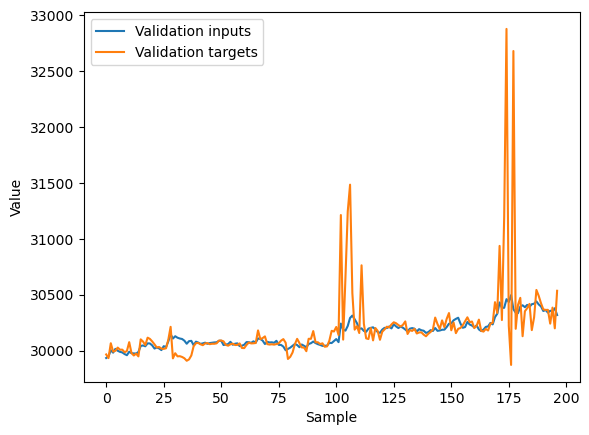

In [129]:
import matplotlib.pyplot as plt

# Plot validation inputs and targets
plt.plot(val_outputs, label='Validation inputs')
plt.plot(prediction, label='Validation targets')

# Set axis labels and legend
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()